In [ ]:
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=ce6261e680ce4fe372941aa1e83aff649263e27dd4435195c60a21694c67c958
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from yahoofinancials import YahooFinancials
from datetime import datetime
from timeit import default_timer
import seaborn as sns

In [ ]:
def step_function(r, x_t, f_x, g,  d_t, x0, L): #Algorithm 3
    if type(x0) == int:
        x0 = x_t 
        #print("x0:", x0)
    epsilon = 10e-3
    k1 = 0.9
    k2 = 2
    nL = k1 * L
    den=d_t.T @ d_t # ||d||^2
    if den==0: # since it goes to the denominator I check that it is not 0
      den=0.0000001 #think about substituting this with a stop of the algorithm
    clip = g ** 2 / ((2 * (objective(x0, r) - f_x) * den)+0.0000001) # this value ha to be comprised between nL and L
    
    M = np.clip(clip ,nL, L) ## the value clip is bounded by upper bound nL and lower bound L 
    
        
        
    
    bound = g / (M * den) 
    gamma = min(bound, 1)
    #whiel the function is bigger than quadratic approximation do:
    while objective(x_t + (gamma * d_t), r) > (f_x - (gamma * g) + ( (gamma ** 2) * M) * (den)) : 
        M = k2 * M
        bound = g / ((M * den)+0.0000001) 
        
        gamma = min(bound, 1)
    return gamma,  M

The computation of the cost function can be seen as matrix multiplication between:

*    $R$ with size $(m, n)$, where $m$ is the number of periods and $n$ is the number of assets, so that the row $i$ represents the value of the return of each assets in the period $i$
*   $x$ that is the column vector with shape $(n, 1)$ that gives us the percentage to invest for each asset.

In this way the matrix multiplication between each row of $R$ and $x$ will correspond to exponential of the each element of the summatory $\sum_{i=1}^{T} ln(r_{i}x)$, where $T$ is the number of period. So what is left is to apply the logaritmic function to every of those terms.



In [ ]:
def objective(x, r):
  x=x.reshape(-1,1) #reshape the vector to perform the next operation
  a=np.dot(r, x ) #dot product
  a=np.where(a!=0, a, a+0.0001) 
  
  #print('o', np.sum(a))#eleminating eventual zero elements
  #a will be a vector of m elements, one for each period
  return np.sum(-np.log(a))

The computation of the gradient follows the same logic as before, we will get a colum vector of 250 elements, and then we will perform an element wise multiplication between this vector and the matrix $R$. After this we will sum with respect to the colum in order to get the gradient for each element of $x$.

In [ ]:
def gradient(x, r):
  x=x.reshape(-1,1)
  a=np.dot(r, x )
  a=np.where(a!=0, a, a+0.0001) #up to here same as befor
  
  return np.sum(-(1/a)*r, axis=0) # multiplying for R and summing with respect to the column

In [ ]:
def arimjo_ls(xt, fx, gamma_max, gt, dt, r):
    gamma = gamma_max
    p = 0.1*(-gt) # quantity that goes in the armijo line search
    f= objective(xt + gamma * dt, r)
    while (f > (fx + gamma * p)): # while the function is biggr than the linear approximation
      gamma=0.7*gamma #reduce the step size
      f = objective(xt + gamma * dt, r) 
    return gamma
    

In [ ]:
def LMO(gradient_xt): 
    sti = np.argmin(gradient_xt) 
    st = np.zeros(gradient_xt.shape[0])
    st[sti]=1 # simplex[sti] only thing left to be defined is simplex
    return st, sti

In [ ]:
def frank_wolfe(objective, gradient, return_matrix, max_iter):
    # n_periods = return_matrix.shape[0]
    n_assets = return_matrix.shape[1]
    
    eps = 1e-6
    # Our solution is a vector x, |x| = n_assets - 
    # investment distribution
    # We pick initial approximation for x - any
    # simplex vertex
    vertex_to_start = 1
    assert vertex_to_start < n_assets, print('Pick another initial approximation')
    x = np.zeros(n_assets)
    x[vertex_to_start] = 1  # initial approximation - all money to one asset

    objective_values = [objective(x, return_matrix)]  # objective function
    gap_list=[]

    algo_start = default_timer()
    iterations_counter = 0
    for k in range(1, max_iter + 1):
        iterations_counter += 1
        # Compute gradient of objective function
        grad_vector = gradient(x, return_matrix)
        #assert(grad_vector.shape[0] == len(x))

        # FW for simplex problem --> minimum of linear
        # function will be reached on the vertex of the simplex
        # Here we search for index with minimum gradient
        # component
        min_index = np.argmin(grad_vector)
        #assert grad_vector[min_index] <= 0, print(f'Minimum of gradient vector is positive')
        
        # x_k^ = e_ik from lectures - direction where to go
        xk_hat = np.zeros(n_assets)
        assert(len(xk_hat) == len(grad_vector))
        xk_hat[min_index] = 1
        d = (xk_hat - x)
        gap=-grad_vector @ d
        gap_list.append(gap)
        if gap <= eps:
            print(f'Satisfied exiting condition')
            break
        else:
            learning_rate = 2 / (k + 1)
            x = x + learning_rate * d
            obj = objective(x, return_matrix)
            
            objective_values.append(obj)  # objective function
    # that sum of distribution is 100%
    algo_end = default_timer()
    delta_t = algo_end - algo_start
    return x, objective_values, gap_list, iterations_counter

In [ ]:
def variant2(objective,  gradient, r,  max_iter = 1000):
  eps = 1e-6
  
      
  xt  = np.zeros(r.shape[1])
  xt[0]=1
  x0=0 #initialize this variable to keep track of the previus value of x w.r.t. to the curret iteration
  #it is needed in the step_function
  gap_list=[]
  
  o=[] #store the objective function values during the iteration
  algo_start = default_timer()
  for i in range(max_iter):
    if i==0:
        
        L=1 #initialize the L costant, to be sostituted with the right euristic
    
    g  = gradient(xt, r)
    fxt  = objective(xt,r )
    o.append(fxt)
    st, sti = LMO(g)#linear minimizer oracle
    d =  st - xt 
    gap=- g @ d #computing the gap
    gap_list.append(gap)
    if gap<= eps: #checking the stopping condition
      print('early exit')
      algo_end = default_timer()
      delta_t = algo_end - algo_start
      return [xt, o, gap_list, i]
    gamma, L = step_function(r, xt, fxt, gap,  d, x0, L)
    x0=xt #keeping track of the past value of x for the next iteration
    xt += gamma*d #updating x
  algo_end = default_timer()
  delta_t = algo_end - algo_start
  return [xt,  o, gap_list, max_iter]

In [ ]:
def FW_PW_correct(objective,  gradient, r,  max_iter = 1000):
    eps = 1e-6
    #active_set=np.eye(r.shape[1]) # the active set has as vertexes the characteristic vectors
    gap_list=[]
    
    
    #xt  = active_set[0, :] #itiliaze x with the fisrt vertex
    #for the part of the code concerning the weights see the paper for a more detailed explenations
    ind=[0] #list of indexes correspondig to the vertexes that are into set1 (see below)
    #weights = np.zeros(r.shape[1]) #we have a weight for each vertex of the active set
    #we also have another set (set1 corresponding to S in the paper) where there 
    #are all the vertexes that can be chosen to compute the away direction
    xt=np.zeros(r.shape[1])
    xt[ind]=1
    #weights[ind] = 1 #we set the weights corresponding to the vertexes that are in set1 equal to one, the rest is equal to zero
    
    o=[] 
    algo_start = default_timer()
    for i in range(max_iter):
        
        #set1=active_set[ind,:] #create the set1 where there are all the vertexes with the corresponding weights different from 0
        g  = gradient(xt, r)
        fxt  = objective(xt,r )
        o.append(fxt)
        st, sti = LMO( g) #linear minimizer oracle
        vti = np.argmax(g[ind])
        

        vti=ind[vti] #trick, since vti will correspond to the index in set1, that is smaller than active set 
        #I retrive the corresponding index in the active set
        vt=np.zeros(xt.shape[0]) #away vertex
        vt[vti]=1
        dt = st - vt #pairwise direction
        gfw =  - g @ dt #gap
        gap_list.append(gfw)
        if gfw <= eps: #stopping condition
          print('early exit')
          algo_end = default_timer()
          delta_t = algo_end - algo_start
          return [xt, o, gap_list, i]
         
        gamma_max = xt[vti] #gamma max equal to the weight corresponding to the away vertex
        
        gamma = arimjo_ls(xt, fxt, gamma_max, gfw, dt, r)
        #weights[vti] -= gamma #updating the weights according to the paper
        #weights[sti] += gamma
         #updating the list of indexes correspondig to the non zero weights
        if (abs(xt[vti]) <= 0.0001): #removing weights that are too little
            #active_set = np.delete(active_set, vti, 0)
            xt[vti]=0
        ind=(np.array(list(range(xt.shape[0])))[(xt>0)]).tolist()
        
        
        
        xt += gamma*dt
    algo_end = default_timer()
    delta_t = algo_end - algo_start
    return [xt,  o, gap_list, max_iter]

In [ ]:
def plot_objective_function(values):
    fontsize = 20
    labelsize = 16
    fig, ax = plt.subplots()

    for a, s in values.items():
        ax.plot(s, marker = 'o', markerfacecolor = 'white', label=a)
        leg = ax.legend()
    plt.xlabel('Number of iteration')
    plt.ylabel('Objective function')
    plt.title('Objective function')
    plt.grid()

In [ ]:
def plot_gap(values):
    fontsize = 20
    labelsize = 16
    fig, ax = plt.subplots()

    for a, s in values.items():
        ax.plot(s, marker = 'o', markerfacecolor = 'white', label=a)
        leg = ax.legend()
    plt.xlabel('Number of iteration')
    plt.ylabel('Relative Error')
    plt.title('Relative Error')
    plt.grid()

In [ ]:
def plot_return_matrix(return_matrix, x_lim, assets):
    fig, ax = plt.subplots()
    
    for asset in assets:
        ax.plot(return_matrix[:x_lim, asset], marker = 'o', markerfacecolor = 'white')

    plt.ylim([0, 1.5])
    plt.xlabel('Period 1 .. T')
    plt.title(f'First {x_lim} samples for {len(assets)} assets')
    plt.ylabel('Return')
    plt.legend([f'Asset {n}' for n in assets])
    plt.grid()

In [ ]:
def plot_bar_scores(scores_dict, y_label, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(y_label, fontsize = 18)
    ax.set_title(title, fontsize = 18)

    x_vals = scores_dict.keys()
    y_vals = scores_dict.values()
    
    ax.bar(x_vals, y_vals, width = 0.4)
    ax.tick_params(labelsize = 16)
    plt.grid()
    plt.show()

In [ ]:
type(None)==type(None)

True

In [ ]:
def run_experiment(n_assets, n_periods, max_iterations, fun, return_matrix=None):
    mean = 0  # like in paper
    var = 0.1  # like in paper
    np.random.seed(43)
    i={}
    o={}
    g={}
    t={}
    n_iterations = {}
    # Create return matrix as in the paper
    # (N periods) x (N assets) matrix
    if type(return_matrix)==type(None):
      return_matrix = np.ones((n_periods, n_assets)) + np.random.normal(loc = mean, scale = var, size = (n_periods, n_assets))
      assert(return_matrix.shape == (n_periods, n_assets))
      assert(len(return_matrix[:, 0]) == n_periods)
      assert(len(return_matrix[0, :]) == n_assets)

    plot_return_matrix(return_matrix, x_lim = 100, assets = [0, 1, 2])

    for f in fun:
      start=time.time()
      investment_distribution, objective_func, gap, n_iters = f(objective,  gradient, return_matrix,  max_iter = max_iterations)
      stop=time.time()
      
      i[f'{f.__name__}']=investment_distribution
      o[f'{f.__name__}']=objective_func
      g[f'{f.__name__}']=gap
      t[f'{f.__name__}']=[stop-start]
      n_iterations[f'{f.__name__}'] = n_iters

      if investment_distribution.sum()>=0.999:
        print(f'{f.__name__}', ' has done a correct execution')

    plot_objective_function(o)
    plot_gap(g)
    
    plot_bar_scores(
        n_iterations, 
        'Number of iterations', 
        'Iterations of algorithms'
    )

    plot_bar_scores(
        {k: v[0] for k, v in t.items()}, 
        'CPU time, sec', 
        'Computational time of algorithms'
    )

    invest_distributions = np.array([v for v in i.values()])
    sns.heatmap(invest_distributions)

    display('Time to execution', pd.DataFrame(t))
    return i, o, g, t, n_iterations

frank_wolfe  has done a correct execution
variant2  has done a correct execution
FW_PW_correct  has done a correct execution


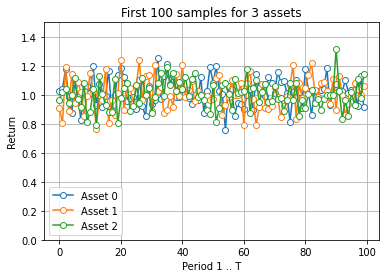

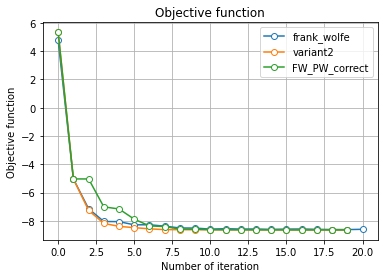

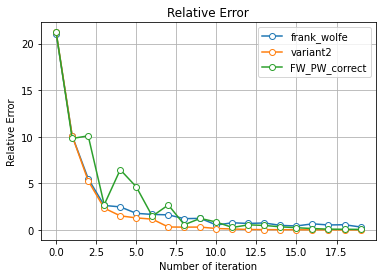

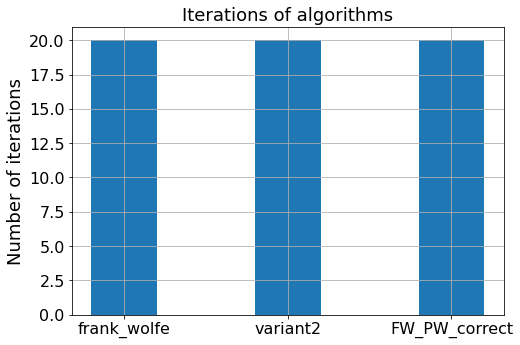

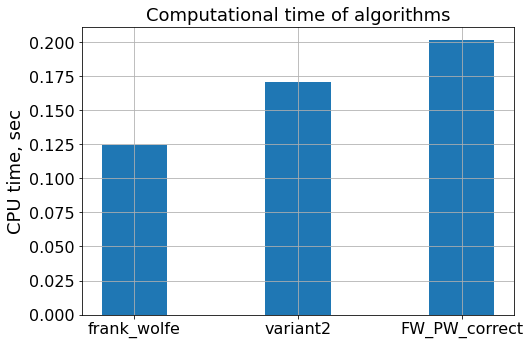

'Time to execution'

,frank_wolfe,variant2,FW_PW_correct
0,0.124781,0.170297,0.201252


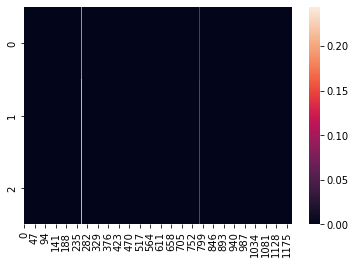

In [ ]:

investments, objective_func, g, t, it = run_experiment(1200, 1000, 20, [frank_wolfe, variant2, FW_PW_correct])


In [ ]:
ticker_details = pd.read_csv('/content/nasdaq_screener.csv')

In [ ]:
ticker = ticker_details['Symbol'].to_list()
names = ticker_details['Symbol'].to_list()

In [ ]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2022-03-09"
start_date = "2020-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
values = pd.DataFrame({ 'Date': date_range})
values['Date']= pd.to_datetime(values['Date'])

In [ ]:
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    if 'Common' not in ticker_details[ticker_details['Symbol']==i]['Name'].to_string():
      continue
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    
    if 'prices' not in raw_data[i].keys():
      continue
    if raw_data[i]['prices']==[]:
      continue
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    
    df.columns = ['Date1',i]
    df['Date1']= pd.to_datetime(df['Date1'])
    values = values.merge(df,how='left',left_on='Date',right_on='Date1')
    values = values.drop(labels='Date1',axis=1)



In [ ]:
names.insert(0,'Date')
#values.columns = names
print(values.shape)
print(values.isna().sum())
values.tail()

(571, 2938)
Date        0
AACG       21
AACI_x    490
AACIU     428
AADI_x     21
         ... 
ZVO        21
ZWRK      336
ZY        349
ZYNE       21
ZYXI       21
Length: 2938, dtype: int64


,Date,AACG,AACI_x,AACIU,AADI_x,AAL_x,AAME_x,AAOI_x,AAON_x,AAPL_x,...,ZNTL,ZS,ZSAN,ZTEK,ZUMZ,ZVO,ZWRK,ZY,ZYNE,ZYXI
566,2022-03-03,1.24,9.81,9.84,16.980000,15.71,2.506154,3.60,53.821220,165.986115,...,47.259998,242.029999,6.335,2.73,46.009998,1.090,9.76,3.44,1.96,5.66
567,2022-03-04,1.21,9.81,9.84,16.930000,14.59,2.406703,3.41,54.130138,162.930603,...,45.570000,225.500000,5.845,2.57,44.500000,1.015,9.76,3.23,1.90,5.28
568,2022-03-07,1.20,9.82,9.84,17.059999,12.84,2.327143,3.56,54.100246,159.066299,...,44.810001,204.369995,5.495,2.59,41.060001,1.050,9.75,3.21,1.92,5.57
569,2022-03-08,1.24,9.83,9.84,17.860001,13.51,2.207802,3.73,53.382759,157.209015,...,44.000000,198.630005,5.425,2.18,43.040001,1.070,9.76,3.37,1.96,5.85
570,2022-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
values.to_csv('dataset_for_o4ds')

In [ ]:
values=pd.read_csv('/content/dataset_for_o4ds')

In [ ]:
values.head()

,Unnamed: 0,AACG,AADI_x,AAL_x,AAME_x,AAOI_x,AAON_x,AAPL_x,AATC_x,AAWW_x,...,ZION,ZIVO,ZM,ZS,ZSAN,ZTEK,ZUMZ,ZVO,ZYNE,ZYXI
0,1,1.35,9.600,28.982893,1.968785,12.50,49.139999,73.785919,4.233618,27.730000,...,48.681541,0.16,68.720001,47.330002,53.200001,0.27,34.090000,2.06,5.88,7.121037
1,2,1.47,9.600,27.548195,2.018252,12.12,49.593082,73.068558,4.270353,27.450001,...,47.994579,0.16,67.279999,47.380001,54.250000,0.27,33.830002,2.05,5.81,7.507659
2,3,1.43,9.720,27.219410,1.840171,12.15,49.504436,73.650787,4.187700,27.430000,...,47.409729,0.16,70.320000,48.700001,57.400002,0.28,34.410000,2.07,5.70,7.570597
3,4,1.43,9.945,27.119778,1.780811,12.43,49.396095,73.304413,4.251986,26.370001,...,47.121948,0.16,71.900002,48.400002,59.849998,0.27,34.180000,2.01,5.56,7.678492
4,5,1.51,9.255,27.737495,1.879745,12.70,49.258198,74.483597,4.297903,27.160000,...,47.586113,0.16,72.550003,50.750000,56.700001,0.27,34.480000,1.91,5.31,7.615553


In [ ]:
values=values.drop(['Unnamed: 0'], axis=1)

In [ ]:
np.unique(values.isna().sum(), return_counts=True)

(array([0]), array([2214]))

In [ ]:
for i in list(values.columns):
  if values[i].isna().sum()!=21:
    values=values.drop([i], axis=1)

In [ ]:
values[values.isna().any(axis=1)].shape

(21, 2214)

In [ ]:
values=values.dropna(axis=0)

In [ ]:
values.head()

,AACG,AADI_x,AAL_x,AAME_x,AAOI_x,AAON_x,AAPL_x,AATC_x,AAWW_x,ABCB_x,...,ZION,ZIVO,ZM,ZS,ZSAN,ZTEK,ZUMZ,ZVO,ZYNE,ZYXI
0,1.35,9.600,28.982893,1.968785,12.50,49.139999,73.785919,4.233618,27.730000,41.095348,...,48.681541,0.16,68.720001,47.330002,53.200001,0.27,34.090000,2.06,5.88,7.121037
1,1.47,9.600,27.548195,2.018252,12.12,49.593082,73.068558,4.270353,27.450001,40.931892,...,47.994579,0.16,67.279999,47.380001,54.250000,0.27,33.830002,2.05,5.81,7.507659
2,1.43,9.720,27.219410,1.840171,12.15,49.504436,73.650787,4.187700,27.430000,40.806889,...,47.409729,0.16,70.320000,48.700001,57.400002,0.28,34.410000,2.07,5.70,7.570597
3,1.43,9.945,27.119778,1.780811,12.43,49.396095,73.304413,4.251986,26.370001,40.528053,...,47.121948,0.16,71.900002,48.400002,59.849998,0.27,34.180000,2.01,5.56,7.678492
4,1.51,9.255,27.737495,1.879745,12.70,49.258198,74.483597,4.297903,27.160000,41.008812,...,47.586113,0.16,72.550003,50.750000,56.700001,0.27,34.480000,1.91,5.31,7.615553


In [ ]:
x1=values.to_numpy()
x1=x1[0:values.shape[0]-1, :]
x2=values.to_numpy()
x2=x2[1:values.shape[0], :]

In [ ]:
real_return = x2/x1

frank_wolfe  has done a correct execution
variant2  has done a correct execution
FW_PW_correct  has done a correct execution


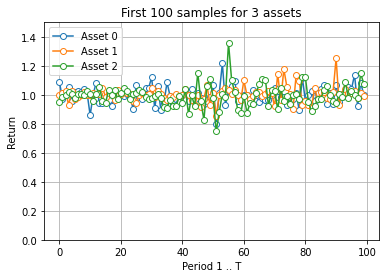

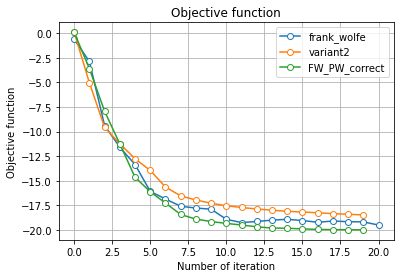

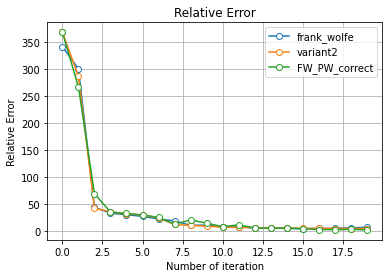

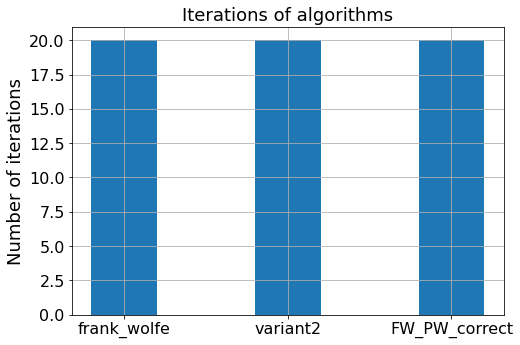

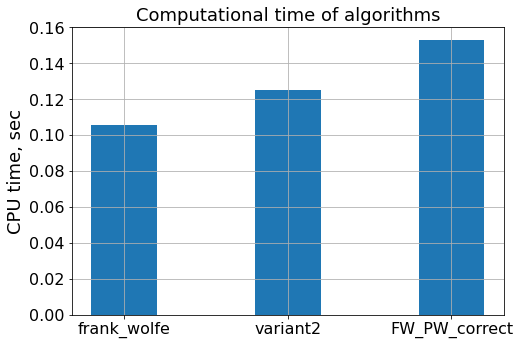

'Time to execution'

,frank_wolfe,variant2,FW_PW_correct
0,0.105397,0.12483,0.152635


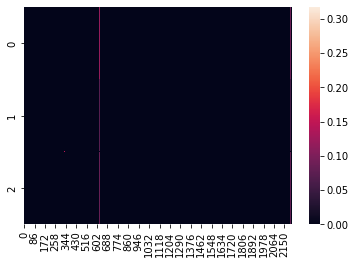

In [ ]:
investments, objective_func, g, t, it = run_experiment(1200, 1000, 20, [frank_wolfe, variant2, FW_PW_correct], real_return)